# Определение возраста покупателей

**Описание проекта**

Сетевой супермаркет «Хлеб-Соль» (название вымышленное) внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В моём распоряжении набор фотографий людей с указанием возраста.

Изучим имеющиеся данные и попытаемся построить модель компьютерного зрения для решения поставленной задачи.

**Задачи:**

- Провести исследовательский анализ набора фотографий.
- Подготовить данные к обучению.
- Обучить нейронную сеть и рассчитать её качество.
- Значение метрики MAE не должно быть выше значения: 8.

## Исследовательский анализ данных

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import seaborn as sns

In [3]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
labels.shape

(7591, 2)

Построим график распределения возростов в нашей выборке:

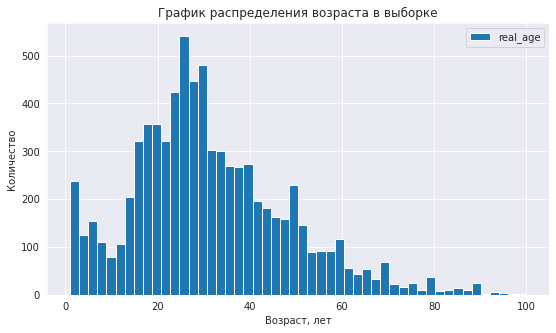

In [6]:
sns.set_style("dark")
labels.plot(kind='hist',figsize=(9,5),bins=50, grid=True)
plt.title('График распределения возраста в выборке')
plt.xlabel('Возраст, лет')
plt.ylabel('Количество')
plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


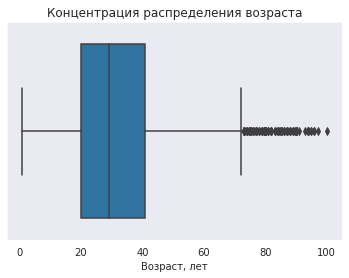

In [7]:
sns.boxplot(labels['real_age'])
plt.title('Концентрация распределения возраста')
plt.xlabel('Возраст, лет')
plt.show()

In [8]:
print(labels.describe())

          real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000


Теперь посмотрим на фотографии. Выведем 16 изображений:

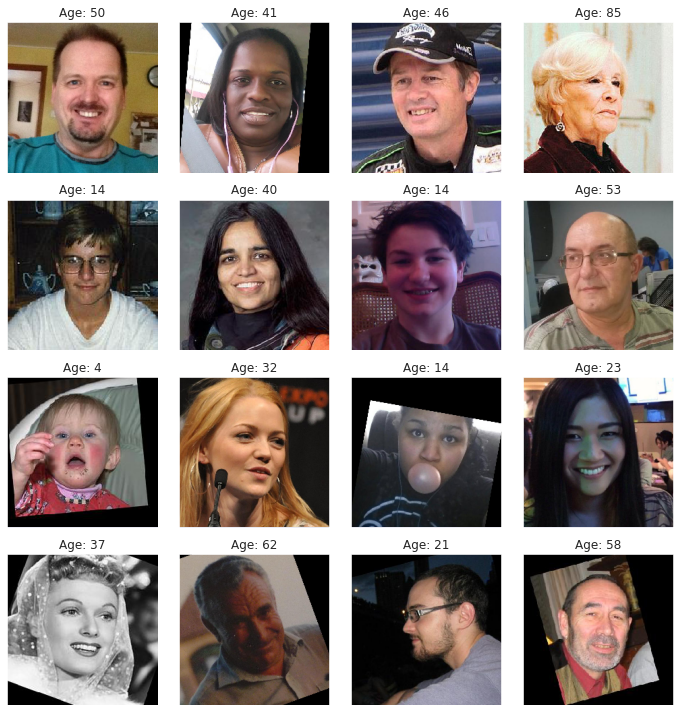

In [9]:
features, target = next(train_gen_flow)
fig = plt.figure(figsize=(10, 10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title('Age: {}'.format(target[i]))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Вывод

- В датасете 7591 фотографий (Небольшая выборка для оценки возраста).
- Больше всего фотографий в диапазоне от 20 лет до 41 года
- В выборке размечены дети и старики. На возрасте 60+ довольно мало примеров, вероятно на этих возрастах модель плохо обучится и будут ошибки на предсказаниях пожилых людей. И имеется пик на возрасте до 10-и лет. Видимо присутствует довольно много фотографий маленьких детей. Это не плохо, но для магазина это не особо нужно. По сути, если эту категорию исключить из обучения, то на результат это не должно негативно повлиять
- Распределение по возрастам выглядит нормальным, выбросов не наблюдается. Имеются пики на круглых числах. Возможно, это связано с тем, что у некоторых изображений указывался примерный возраст, то есть округлялся до десятков
- Фотографии выглядят хорошо, без явных искажений в области лица. Чтобы улучшить обучение, думаю будет полезным, применить горизонтальный разворот изображений в обучающей выборке.
- На фотографиях присутствуют объекты, которые закрывают лицо: рука, жвачка, очки, головной убор и т.д.

С учетом вложенных фотографий модели, будет нелегко оценивать возраст. 

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

Создадим функции для загрузки выборок:

Создадим обучающую выборку. В ней применим горизонтальный поворот. Создадим тестовую выборку и создадим функцию в которой сконструируем модель. Будем использовать ResNet50 в сочетании с GlobalAveragePoolingи выходным слоем в 1 нейрон с функцией активации ReLu, так как значения ниже нуля нам не нужны. Accuracy будем измерять метрикой MAE. Создадим функцию обучения модели. Обучим модель на 10-и эпохах:

In [10]:
def load_test(path):
    labels = pd.read_csv(path+'labels.csv') 
    test_datagen = ImageDataGenerator(rescale=1./255,
                                    validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345) 
    return test_datagen_flow


def load_train(path):
    labels = pd.read_csv(path+'labels.csv') 
    train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.25,
                                   horizontal_flip=True,
                                   brightness_range=(0.8, 1.))

    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
      directory=path + 'final_files/',
      x_col='file_name',
      y_col='real_age',
      target_size=(224, 224),
      batch_size=32,
      class_mode='raw',
      subset='training',
      seed=12345)
    return train_datagen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D()) 
    model.add(Dense(1, activation='relu')) 
    optimizer = Adam(lr=0.0003)
    model.compile(optimizer=optimizer,loss='mse',metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

Результат работы модели, вывод на экран:

**Train for 178 steps, validate for 60 steps**

Epoch 1/10

178/178 - 82s - loss: 197.5296 - mae: 10.2958 - val_loss: 398.0144 - val_mae: 14.9553

Epoch 2/10

178/178 - 52s - loss: 94.9183 - mae: 7.3325 - val_loss: 376.2147 - val_mae: 14.4622

Epoch 3/10

178/178 - 54s - loss: 70.9457 - mae: 6.3353 - val_loss: 236.6779 - val_mae: 11.6138

Epoch 4/10

178/178 - 54s - loss: 54.8452 - mae: 5.6408 - val_loss: 175.1937 - val_mae: 9.6972

Epoch 5/10

178/178 - 53s - loss: 41.7302 - mae: 4.9208 - val_loss: 124.8040 - val_mae: 8.5844

Epoch 6/10

178/178 - 51s - loss: 35.2795 - mae: 4.5326 - val_loss: 84.4690 - val_mae: 6.7345

Epoch 7/10

178/178 - 49s - loss: 27.2924 - mae: 3.9848 - val_loss: 90.7920 - val_mae: 7.0660

Epoch 8/10

178/178 - 49s - loss: 25.7454 - mae: 3.8559 - val_loss: 84.8817 - val_mae: 6.9502

Epoch 9/10

178/178 - 49s - loss: 21.5213 - mae: 3.5439 - val_loss: 107.0267 - val_mae: 8.2650

Epoch 10/10

178/178 - 52s - loss: 17.4843 - mae: 3.2141 - val_loss: 79.2708 - val_mae: 6.6439

60/60 - 11s - loss: 79.2708 - mae: 6.6439

Test MAE: 6.6439

**Лучший результат MAE на тестовой выборке: 6.6439. Цель достигнута (ниже 7)**

## Анализ обученной модели

Перед нами стояла задача построить и обучить модель, которая поможет определять возраст человека по изображению с камеры со средним абсолютным отклонением MAE не выше 7.

- В нашем распоряжении был датасет с 7591 размеченной фотографией, среди которых преимущественно были фотографии выполненные при слабом освещении и с вращением по горизонтальной оси. Для того, чтобы модель обучилась точнее мы предварительно отделив % данных для тренировки модели, использовали специальные гиперпараметры, которые добавили в тренировочную выборку фотографии с похожими эффектами, а оставшиеся % оставили без изменений для тестирования модели.

- В качестве основы за модель взяли уже предобученную нейросеть с архитектурой ResNet50 и дополнительно обучили её на наших данных без замораживания. В выходном слое,для более точного обучения модели, использовали оптимизацию Adam c шагом обучения 0.003, а в качестве функции потерь использовалась mean_squared_error (mse).

С такими параметрами мы протестировали нашу модель на  эпохах и уже на 6 эпохе обучения на тестовых данных, она достигла значения по метрике MAE равное 6.7345, что уже меньше 7. Таким образом мы достигли требуемой точности предсказания возраста нашей моделью и смело можем рекомендовать её к использованию.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы